# 1 Dependency import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
def dataframe_distribution_overview(data, figsize=(10, 3)):
    plt.figure(figsize=figsize)

    sns.barplot(x=data.columns, y=data.count())

    plt.title("Number of values per column", size=20)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.ylabel("Number values", size=16)
    plt.show()

In [3]:
def index_lth(data, percentage: int):
    percentage = percentage / 100
    less_than = data.count() < data.shape[0] * percentage
    index_less_than = less_than[less_than == True].index
    return index_less_than

In [4]:
def multi_boxplot(data, features):
    n_cols = 8
    n_rows = ceil(data.loc[:, features].shape[1] / n_cols)
    index = 1

    plt.subplots(n_rows, n_cols, figsize=(30, 10))
    plt.subplots_adjust(wspace=0.35, hspace=0.35)

    for r in range(n_rows):
        for c in range(n_cols):
            plt.subplot(n_rows, n_cols, index)
            feature = data.loc[:, features].iloc[:, index-1].name
            boxplot = sns.boxplot(y=data[feature])
            boxplot.set_xlabel(feature, fontsize=12)
            boxplot.set_ylabel(None)
            
            index += 1

            if index > data.shape[1]:
                break
    plt.show()

In [5]:
# def create_subplot(data, feature, rows, index, is_numeric):
#     lt.subplot(n_rows, 2, index+1)
#     if is_numeric:
#         boxplot = sns.boxplot(y=data2[f])
#         boxplot.set_xlabel(feature, fontsize=12)
#         boxplot.set_ylabel(None)
#     else:
#         countplot = sns.countplot(y=data2[f])
#         countplot.set_xlabel(feature, fontsize=12)
#         countplot.set_ylabel(None)

# def dataset_diff_analysis(data1, data2, features):
#     n_rows = len(features)
#     col_id = 0
#     index = 1

#     plt.subplots(n_rows, 2, figsize=(30, 10))
#     plt.subplots_adjust(wspace=0.35, hspace=0.35)

#     for f in features:
#         is_numeric = True
#         if data1[f].dtype == "object":
#             is_numeric = False

#         create_subplot(data1, f, n_rows, index, is_numeric)
#         create_subplot(data2, f, n_rows, index, is_numeric)

#     index += 2

#     plt.show()

In [6]:
class OutlierProcessor():
    def __init__(self, data, feature, lower_trig, upper_trig):
        self.data = data
        self.feature = feature
        self.lower_trig = lower_trig
        self.upper_trig = upper_trig
        self.__above = 0
        self.__below = 0
        self.__total = 0

    def __print(self):
        print(f"lower_trig: {self.lower_trig}")
        print(f"upper_trig: {self.upper_trig}")
        print(f"below: {self.__below}")
        print(f"above: {self.__above}")
        print(f"total: {self.__total}")

    def count(self):
        self.__below = self.data[self.data[self.feature] < self.lower_trig][self.feature].count()
        self.__above = self.data[self.data[self.feature] > self.upper_trig][self.feature].count()
        self.__total = self.__below + self.__above
        self.__print()

    def replace(self, replace_by=np.nan, inplace=False):
        return self.data[self.feature].where(cond=lambda x: ((x > self.lower_trig) & (self.upper_trig > x)), other=replace_by, inplace=inplace)


In [7]:
class OutlierIqrProcessor(OutlierProcessor):
    def __init__(self, data, feature):
        self.__q1 = data[feature].quantile(0.25)
        self.__q3 = data[feature].quantile(0.75)
        self.__iqr = self.__q3 - self.__q1
        upper_trig = self.__q3 + (1.5 * self.__iqr)
        lower_trig = self.__q1 - (1.5 * self.__iqr)
        super().__init__(data, feature, lower_trig, upper_trig)


***
# 2 Data loading

## 2.1 Loading

In [8]:
data = pd.read_csv("data/2015-building-energy-benchmarking.csv", delimiter=",")

In [9]:
data2 = pd.read_csv("data/2016-building-energy-benchmarking.csv", delimiter=",")

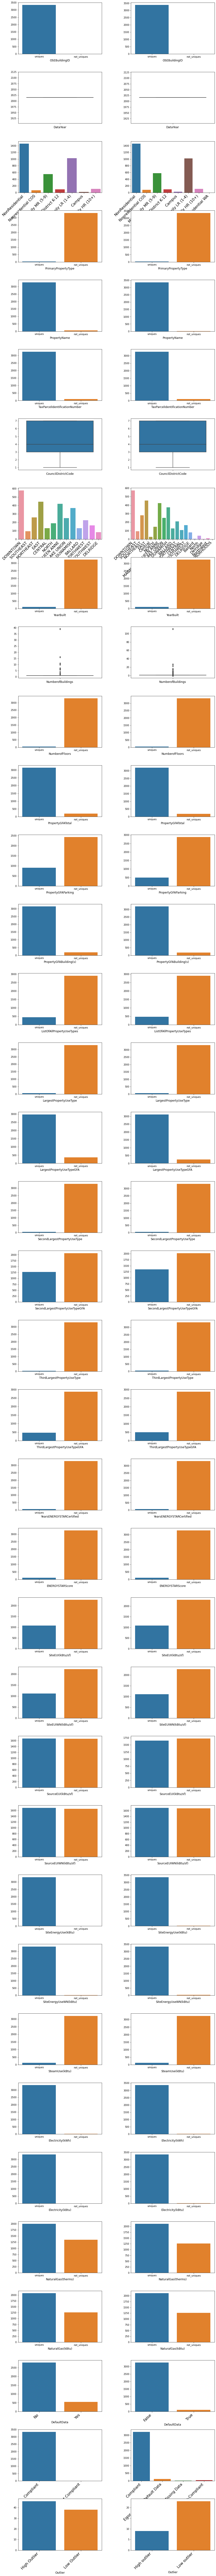

In [10]:
def create_subplot(dataset, feature, n_rows, index, is_numeric):
    plt.subplot(n_rows, 2, index)
    uniques = dataset[feature].unique()
    if uniques.size <= 20 and uniques.size > 0:
        if is_numeric:
            plot = sns.boxplot(y=dataset[feature])
        else:
            plot = sns.countplot(x=dataset[feature])
            plt.xticks(rotation=45, size=16, ha="right")
    else:
        dist = pd.DataFrame(data=[[uniques.size, dataset.shape[0] - uniques.size]], columns=["uniques", "not_uniques"])
        plot = sns.barplot(data=dist)

    plot.set_xlabel(feature, fontsize=12)
    plot.set_ylabel(None)


def dataset_diff_analysis(data1, data2):
    features = data1.columns.intersection(data2.columns).values
    n_cols = 2
    n_rows = len(features)
    col_id = 0
    index = 1

    plt.subplots(n_rows, n_cols, figsize=(15, 200))
    plt.subplots_adjust(wspace=0.35, hspace=0.35)

    for f in features:
        is_numeric = True
        f_type = data1[f].dtype
        if data1[f].dtype == "object":
            is_numeric = False

        create_subplot(data1, f, n_rows, index, is_numeric)
        create_subplot(data2, f, n_rows, index+1, is_numeric)

        index += 2

    plt.show()



dataset_diff_analysis(data, data2)

***
## 2.2 Comparison

In [ ]:
inter_cols = data.columns.intersection(data2.columns)
print(f"nb: {len(inter_cols)}")
inter_cols

In [ ]:
data[data.columns.difference(inter_cols)].columns

In [ ]:
data2[data2.columns.difference(inter_cols)].columns

***
## 2.3 Correction

### 2.3.1 ZipCode

In [ ]:
data["Zip Codes"].describe()

In [ ]:
data2["ZipCode"].describe()

In [ ]:
data.rename(columns={
    "Zip Codes": "ZipCode"
}, inplace=True)

***
### 2.3.2

In [ ]:
data[data["Comment"].notna()].Comment.head()

In [ ]:
data2[data2["Comments"].notna()].Comments.head()

In [ ]:
data2["Comments"].describe()

In [ ]:
data.rename(columns={
    "Comment": "Comments"
}, inplace=True)

***
### 2.3.2 Latitude, Longitude

In [ ]:
data2.loc[:, ["Latitude", "Longitude"]].info()

In [ ]:
data["Latitude"] = pd.Series(data=0, name="Latitude", dtype="float64")
data["Longitude"] = pd.Series(data=0, name="Longitude", dtype="float64")

***
### 2.3.3 Address

In [ ]:
data2["Address"].head()

In [ ]:
data.head()

In [ ]:
data["Address"] = pd.Series(data=np.nan, name="Address", dtype="object")

***
### 2.3.4 Location

In [ ]:
data["Location"].describe()

In [ ]:
data2["Location"] = pd.Series(data=np.nan, name="Location", dtype="object")

***
### 2.3.5 City

In [ ]:
data2["City"].head()

In [ ]:
data.head()

In [ ]:
data["City"] = pd.Series(data=np.nan, name="City", dtype="object")

***
### 2.3.6 GHGEmissionsIntensity

In [ ]:
data2["GHGEmissionsIntensity"].describe()

In [ ]:
data["GHGEmissionsIntensity(kgCO2e/ft2)"].describe()

In [ ]:
data2.rename(columns={
    "GHGEmissionsIntensity": "GHGEmissionsIntensity(kgCO2e/ft2)"
}, inplace=True)

***
### 2.3.7 State

In [ ]:
data2["State"].head()

In [ ]:
data["State"] = pd.Series(data=np.nan, name="State", dtype="object")

***
### 2.3.8 TotalGHGEmissions

In [ ]:
data2["TotalGHGEmissions"].describe()

In [ ]:
data["GHGEmissions(MetricTonsCO2e)"].describe()

In [ ]:
data2.rename(columns={
    "TotalGHGEmissions": "GHGEmissions(MetricTonsCO2e)"
}, inplace=True)

***
### 2.3.9 2010 Census Tracts

In [ ]:
data["2010 Census Tracts"].describe()

In [ ]:
data2["2010 Census Tracts"] = pd.Series(data=np.nan, name="2010 Census Tracts", dtype="float64")

***
### 2.3.10 City Council Districts

In [ ]:
data["City Council Districts"].describe()

In [ ]:
data2["City Council Districts"] = pd.Series(data=np.nan, name="City Council Districts", dtype="float64")

***
### 2.3.11 OtherFuelUse(kBtu)

In [ ]:
data["OtherFuelUse(kBtu)"].describe()

In [ ]:
data2["OtherFuelUse(kBtu)"] = pd.Series(data=np.nan, name="OtherFuelUse(kBtu)", dtype="float64")

***
### 2.3.12 SPD Beats

In [ ]:
data["SPD Beats"].describe()

In [ ]:
data2["SPD Beats"] = pd.Series(data=np.nan, name="SPD Beats", dtype="float64")

***
### 2.3.13 Seattle Police Department Micro Community Policing Plan Areas

In [ ]:
data["Seattle Police Department Micro Community Policing Plan Areas"].describe()

In [ ]:
data2["Seattle Police Department Micro Community Policing Plan Areas"] = pd.Series(data=np.nan, name="Seattle Police Department Micro Community Policing Plan Areas", dtype="float64")

***
### 2.3.14 Results

In [ ]:
inter_cols = data.columns.intersection(data2.columns)
print(f"nb: {len(inter_cols)}")
inter_cols

In [ ]:
data[data.columns.difference(inter_cols)].columns

In [ ]:
data2[data2.columns.difference(inter_cols)].columns

***
## 2.4 Concatenation

In [ ]:
data = pd.concat([data, data2])

In [ ]:
def multi_boxplot(data, features):
    n_cols = 8
    n_rows = ceil(data.loc[:, features].shape[1] / n_cols)
    index = 1

    plt.subplots(n_rows, n_cols, figsize=(30, 10))
    plt.subplots_adjust(wspace=0.35, hspace=0.35)

    for r in range(n_rows):
        for c in range(n_cols):
            plt.subplot(n_rows, n_cols, index)
            feature = data.loc[:, features].iloc[:, index-1].name
            boxplot = sns.boxplot(y=data[feature])
            boxplot.set_xlabel(feature, fontsize=12)
            boxplot.set_ylabel(None)
            
            index += 1

            if index > data.shape[1]:
                break
    plt.show()

In [ ]:
# dataset_diff_analysis(data, data2)

***
# 3 Overview

In [ ]:
dataframe_distribution_overview(data, figsize=(30, 3))

***
# 4 Cleaning

## 4.1 Target

In [ ]:
target = "SiteEnergyUse(kBtu)"

In [ ]:
data[data[target].isna()].loc[:, [target]]

In [ ]:
data.dropna(subset=["SiteEnergyUse(kBtu)"], inplace=True)

In [ ]:
data[data[target].isna()].loc[:, [target]]

***
## 4.1 Emptyness

In [ ]:
cols_to_remove = index_lth(data, 10)

In [ ]:
data.drop(columns=cols_to_remove, inplace=True)

In [ ]:
dataframe_distribution_overview(data, figsize=(30, 3))

***
## 4.2 Usability

### 4.2.1 Numericals

In [ ]:
numerical_data = data.select_dtypes(["int64", "float64"])

In [ ]:
multi_boxplot(data, numerical_data.columns.values)

In [ ]:
numerical_data.columns

In [ ]:
data["NumberofBuildings"].idxmax()

In [ ]:
data["PropertyGFATotal"].idxmax()

In [ ]:
data["PropertyGFABuilding(s)"].idxmax()

In [ ]:
data.loc[3274]

In [ ]:
len(data.index.unique().values)

In [ ]:
data.shape

In [ ]:
data.duplicated().any()

***
#### 4.2.1.1 OSEBuildingID

In [ ]:
data["OSEBuildingID"].describe()

In [ ]:
op = OutlierIqrProcessor(data, "OSEBuildingID").count()

***
#### 4.2.1.2 PropertyGFATotal

In [ ]:
data["PropertyGFATotal"].describe()

In [ ]:
op = OutlierProcessor(data, "PropertyGFATotal", 0, 3e+06)

In [ ]:
op.count()

In [ ]:
# op.replace(inplace=True)

***
#### 4.2.1.3 Latitude

In [ ]:
data["Latitude"].describe()

In [ ]:
op = OutlierProcessor(data, "Latitude", 20, 50)

In [ ]:
op.count()

In [ ]:
op.replace(inplace=True)

***
#### 4.2.1.4 Longitude

In [ ]:
data["Longitude"].describe()

In [ ]:
op = OutlierProcessor(data, "Longitude", -130, -50)

In [ ]:
op.count()

In [ ]:
op.replace(inplace=True)

***
### 4.2.2 Categoricals

In [ ]:
categorical_data = data.select_dtypes("object")
categorical_data.describe()

***
# 5 Correlations

In [ ]:
plt.figure(figsize=(30, 20))

correlation = data.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))

sns.heatmap(data=correlation, mask=mask, annot=True, vmax=.75, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation heatmap", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

In [ ]:
categs = data.select_dtypes(include="object")

In [ ]:
def categorize(feature):
    new_feature = feature.astype("category").cat.codes
    return new_feature

In [ ]:
categs_to_nums = categs.apply(lambda col: categorize(col))

In [ ]:
for col in categs_to_nums.columns:
    categs_to_nums.rename(columns={col: col + "_CATEG"}, inplace=True)

In [ ]:
data_enhanced = data.join([categs_to_nums])

In [ ]:
plt.figure(figsize=(30, 20))

correlation = data_enhanced.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))

sns.heatmap(data=correlation, mask=mask, annot=True, vmax=.75, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation heatmap", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

***
# 6 Saving

In [ ]:
data.to_csv("data/data-cleaned.csv", sep=",")

***
# 7 ...